# resolutions and stuff

### lib


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.linalg import expm
from collections import defaultdict
from IPython.display import display
import warnings

from qiskit_aer import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, PhaseEstimation, RXXGate, RYYGate, RZZGate, StatePreparation
from qiskit.circuit.library.data_preparation import StatePreparation
from qiskit.quantum_info import Statevector, partial_trace

### important(?)

- the verbose doesn't draw the circuits anymore, but prints out the info about the circuit via print_qc_info()
- the plots are saved as .pdf

## funcs

In [2]:
def Generate_matrix(matrix_dimension, verbose=False):
    """
    Synthetic matrix generator through input parameters: 
        -   matrix_dimension: int parameter for synthetic matrix generation
        -   eig_values_list: optional eigenvalues list. if not provided, it will be calculated from generated matrix.
    Output :
        - synthetic matrix as numpy matrix.
        - normalization factor
    """


    # Generate hermitian matrix
    random_matrix=np.random.rand(matrix_dimension, matrix_dimension) 
    hermitian_matrix=np.dot(random_matrix, random_matrix.T)

    eig, e_v = np.linalg.eig(hermitian_matrix)
    eig_values_list = np.array(eig)
    e_v_list = np.array(e_v)

    example_matrix = e_v @ np.diag(eig_values_list) @ e_v.T
    
    norm_factor = np.trace(example_matrix)
    normalized_example_matrix = example_matrix/norm_factor

    #if verbose == True:
    #    print(f'Matrix:\n {example_matrix.round(2)}\n')
    #    for eigenval, eigenvec in zip(np.linalg.eig(example_matrix)[0][::-1], np.rot90(np.linalg.eig(example_matrix)[1])):
    #        print(f'eigenvalue: {eigenval:.0f} - eigenvector: {eigenvec.round(3)}')

    return normalized_example_matrix, eig_values_list, e_v_list

def print_qc_info(qc, label="Circuit"):
    print(f"[{label}]: depth={qc.depth()}, num_qubits={qc.num_qubits}, size={qc.size()}, gate count={qc.count_ops()}")


In [3]:
def pad_matrix(input_matr):
    """
    Checks that the given input matrix is a 2D square matrix, and pads with zeros if
    the dimensions are not a power of 2.

    Args:
    input_matr(np.ndarray): 2D square NumPy array to be padded if necessary.

    Returns:
    tuple(np.ndarray, int): Tuple of Zero-padded square matrix with dimensions being
                            the next power of 2, and power of 2 it was padded to.

    Raises:
    ValueError: If the input is not a 2D matrix or if it is not square.

    """

    # check if matrix is 2D
    if input_matr.ndim !=2:
        raise ValueError(f"Input matrix must be 2D, but is {input_matr.ndim}D")
        
    dimA, dimB = input_matr.shape
    # check if matrix is square matrix
    if dimA != dimB:
        raise ValueError(f"Input matrix must be square, but has shape ({dimA}, {dimB})")
        
    # check if the matrix dimension is a power of 2
    # If not, pad with 0
    if not ((dimA & (dimA-1) == 0) and dimA != 0):
        if dimA == 0:
            n = 0
            new_dim = 1
        else:
            n = int(np.ceil(np.log2(dimA)))
            new_dim = 2**n

        padded_matr = np.zeros((new_dim, new_dim))
        padded_matr[:dimA, :dimB] = input_matr
        return padded_matr, n
        
    else:
        return input_matr, int(np.ceil(np.log2(dimA)))

def input_state_preparation(matr, verbose=False):
    """
    Normalizes input matrix and prepares a quantum circuit with the corresponding initial quantum state.

    Args:
        matr (np.ndarray): Input (covariance) matrix .
        verbose (bool, optional): Whether to print debug information and circuit diagram. Default: False.

    Returns:
        tuple: QuantumCircuit and matrix normalization factor.
    """
    
    # normalize it with the trace
    norm_factor = np.trace(matr) 
    matr_normalized = matr / norm_factor

    # check dims and pad with 0 if necessary
    padded_matr, n = pad_matrix(matr_normalized)
    n_qubits = 2*n

    #if verbose: 
    #    print(f'Input Matrix:\n {matr.round(2)}\n')
    #    print(f'Normalization factor:\n {norm_factor.round(2)}\n')
    #    print(f'Padded Normalized Matrix:\n {padded_matr.round(2)}\n')
    #    print(f'# qubits:\n {n_qubits}\n')
    
    # get amplitudes & normalize
    input_ampl = padded_matr.flatten()
    input_ampl /= np.linalg.norm(input_ampl)
    
    # Build the circuit
    qc = QuantumCircuit(n_qubits, name="Init")
    # prepare state
    init = StatePreparation(input_ampl)
    qc.append(init, qc.qubits)

    if verbose:
        print_qc_info(qc, label="Input circuit")
        #print("Initial state circuit:")
        #display(qc.draw('mpl'))

    return qc, padded_matr, norm_factor

def build_PE_circuit(qc_init, U, resolution=4, verbose=False):
    """
    Constructs the phase estimation (PE) circuit with the given initial state and unitary operator.

    Args:
        qc_init (QuantumCircuit): Quantum circuit with the state preparation.
        U (QuantumCircuit or Gate): Unitary operator to be estimated.
        resolution (int, optional): Number of evaluation qubits. Default: 4.
        verbose (bool, optional): Whether to print debug information and circuit diagram. Default: False.

    Returns:
        QuantumCircuit: Phase estimation circuit (with measurements).
    """
    
    # prepare qiskit phase estimation
    pe = PhaseEstimation(num_evaluation_qubits=resolution, unitary=U, name="PE")
    # prepare counting register
    n_qubits_register = resolution + qc_init.num_qubits
    pe_register = QuantumRegister(n_qubits_register, "register")
    # initialize circuit
    pe_circuit = QuantumCircuit(pe_register)
    pe_circuit.append(qc_init, pe_register[resolution:]) # why? don't fully understand that bit
    pe_circuit.append(pe.to_gate(), pe_register[:pe.num_qubits])
    pe_circuit.measure_all()

    if verbose:
        print(f'Resolution: {resolution}')
        print(f'# qubits for PE: {n_qubits_register}')

        print_qc_info(pe_circuit, label="PE Circuit")

        # draw to check
        #print("Phase Estimation circuit:")
        #display(pe_circuit.decompose(reps=2).draw('mpl'))

    return pe_circuit    

def run_PE_circuit(pe_circuit, simulator=AerSimulator(), n_shots=50000, plot_results=False):
    """
    Execute the (PE) QuantumCircuit with the given simulator and return measurement counts.

    Args:
        pe_circuit (QuantumCircuit): (PE) circuit to execute.
        simulator (Backend): Simulator backend to use.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        plot_results (bool, optional): Whether to plot a measurement histogram. Default: False.

    Returns:
        dict: Count dictionary with the measurement results.
    """
    
    # transpile the circuit
    pe_transpiled = transpile(pe_circuit, simulator)
    # run circuit
    pe_result = simulator.run(pe_transpiled, shots=n_shots).result()
    # get counts
    pe_counts = pe_result.get_counts()

    # plotting the counts if desired
    if plot_results:
        print("PE result counts:")
        plot = plot_histogram(pe_counts, figsize=(25, 5))
        display(plot)
        
    return pe_counts

# counts dict by default only contains states that were measured at least once
# so here's quick helper function to get zero count states as well
def complete_counts(counts, n_qubits):
    """
    Add the zero-count states to a qiskit count results dict.

    Args:
        counts (dict): Dictionary of states and measured counts.
        n_qubits (int): Number of measured qubits.

    Returns:
        dict: Dict containing all possible states and counts, incl. zeros.
    """
    keys = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    return {k: counts.get(k, 0) for k in keys}

# TODO: possibly inclcude this in the run_PE_circuit() function instead
def probability_estimation(pe_counts, n_qubits_register, n_shots):
    """
    Compute probability estimates from phase estimation measurement counts.

    Args:
        pe_counts (dict): Measurement counts  from the PE circuit.
        n_qubits_register (int): Number of qubits in the PE cicruit.
        n_shots (int): Number of measurement shots used.

    Returns:
        dict: Dictionary of estimated probabilities for each state.
    """
    # get dictionary with added zero count states 
    pe_counts_tot = complete_counts(pe_counts, n_qubits_register)
    # estimate probs from counts
    probabilities = {state: count / n_shots for state, count in pe_counts_tot.items()}
    return probabilities

def sign_estimation(pe_circuit, init_circuit, probabilities, simulator=AerSimulator(), n_shots=50000, verbose=False):
    """
    Estimates the signs (+1 or -1) of the amplitude coefficients. Constructs and runs a sign estimation circuit from the PE
    and state preparation circuits.

    Parameters:
        pe_circuit (QuantumCircuit): Phase estimation circuit.
        init_circuit (QuantumCircuit): Input state preparation circuit.
        probabilities (dict): Dict of estimated probabilities for each state.
        simulator (Backend, optional): Simulator backend to use for running the circuit. Default: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        verbose (bool, optional): Whether to print debug information, plot circuit diagram and measurement histogram. Default: False.

    Returns:
        dict: Dictionary mapping states to signs (+1 or -1).
    """
    # adjust PE circuit for sign estimation
    pe_circuit.remove_final_measurements() # remove measurements
    
    # prepare unitaries
    U_p = StatePreparation(np.sqrt(list(probabilities.values())),label='U_p').control()
    
    # for U_x, we can't use to_gate bc of StatePreparation
    # so we seperate these parts
    # let's hope this works
    del pe_circuit.data[0] # this is wonky but ok
    # to check:
    if verbose:
        print("PE circuit data :")
        #print(pe_circuit.data)
        print_qc_info(pe_circuit, label="PE Circuit before running?")
        
    # TODO: give the init to the funciton or figure out how to extract!!!!!!   
    U_x_init = init_circuit.control()
    U_x = pe_circuit.to_gate(label='U_x').control()

    n_qubits_pe = pe_circuit.num_qubits
    resolution = n_qubits_pe-init_circuit.num_qubits

    # prepare the sign estimation circuit
    target_register = QuantumRegister(n_qubits_pe, name='Target')
    control_register = QuantumRegister(1, name='Control')
    se_circuit = QuantumCircuit(target_register, control_register, name='SE')
    # add gates
    se_circuit.h(control_register)
    se_circuit.x(control_register)
    se_circuit.append(U_x_init, control_register[:]+target_register[resolution:n_qubits_pe])
    se_circuit.append(U_x, control_register[:]+target_register[:])
    se_circuit.x(control_register)
    se_circuit.append(U_p, control_register[:]+target_register[:])
    se_circuit.h(control_register)
    se_circuit.measure_all()

    if verbose:
        print_qc_info(se_circuit, label="SE Circuit")
        #print("Sign estimation circuit:")
        # draw se circuit
        #display(se_circuit.draw('mpl'))

    # Run the circuit using Aer simulator
    se_transpiled = transpile(se_circuit, simulator)
    
    # run with N shots
    se_result = simulator.run(se_transpiled, shots=n_shots).result()
    se_counts = se_result.get_counts()

    #if verbose: #TODO: or seperate flag for plotting??
    #    print("SE result counts:")
    #    plot = plot_histogram(se_counts, figsize=(25, 5))
    #    display(plot)

    # filter for counts with Control qubit equal 0
    se_counts_filtered = {state[1:]: counts for state, counts in se_counts.items() if state[0]=='0'}
    # pad with zeros?
    # not sure if necessary or correct
    se_counts_filtered = complete_counts(se_counts_filtered, se_circuit.num_qubits-1)
    # compare to find signs:
    sign_dict = {}
    for state, counts in se_counts_filtered.items():
        if counts > 0.4*n_shots*probabilities[state]:
            sign_dict[state] = 1
        else:
            sign_dict[state] = -1
            
    return sign_dict    

def eigen_construction(probabilities, sign_dict, resolution, n_qubits, peak_threshold=0.001, verbose=False):
    """
    Reconstructs eigenvalue-eigenvector pairs from the phase estimation results.

    Args:
        probabilities (dict): Dict of estimated probabilities for each state.
        sign_dict (dict): Dict mapping states to their estimated signs (+1 or -1).
        resolution (int): Number of evaluation qubits used in the PE circuit.
        n_qubits (int): Number of qubits used to encode the input matrix.
        peak_threshold (float, optional): Minimum prominence of a peak in the eigenvalue 
                                          histogram to consider it a valid eigenvalue.
                                          Default: 0.001.
        verbose (bool, optional): Whether to print debug information. Default: False.

    Returns:
        Tuple of lists: List of eigenvalues and list of corresponding eigenvectors.
    """
    # initialise lambdas dict
    lambdas_dict = defaultdict(float) # to avoid missing key checks and init with 0.0
    for state, prob in probabilities.items():
        lam = state[-resolution:]
        lambdas_dict[lam] += prob
    
    # Convert to sorted list
    lambda_keys = sorted(lambdas_dict, key=lambda x: int(x[::-1], 2))
    lambda_probs = np.array([lambdas_dict[k] for k in lambda_keys])
    
    # pad with zeros at start and end for peak finding
    padded_probs = np.concatenate(([0.0], lambda_probs, [0.0]))
    
    # Find peaks
    peaks_idx, _ = find_peaks(padded_probs, threshold=peak_threshold) # TODO: investigate threshold more?
    peak_lambda_keys = [lambda_keys[i-1] for i in peaks_idx]

    #if verbose: 
    #    print("found peaks: ", peaks_idx, peak_lambda_keys) 
    #    print("lambda probs: ", lambda_probs)
    
    eigvals = []
    eigvecs = []
    for lam in peak_lambda_keys:
        # compute and save eigenvalue
        eigval = int(lam[::-1], 2) / 2**resolution
        eigvals.append(eigval)

        if verbose: 
            print(f"\nEigenvalue: {eigval}")
            
        # collect amplitudes from all relevant states
        amps = [
            (state[:-resolution], sign_dict[state] * np.sqrt(probabilities[state]))
            for state in probabilities if state.endswith(lam)
        ]
        # construct amplitude vector sorted by basis state
        vec = np.array([amp for _, amp in sorted(amps, key=lambda x: x[0])])

        vec /= np.linalg.norm(vec)
    
        # find dominant eigvec
        chunks = vec.reshape(-1, n_qubits) # reshape into eigvec-sized chunks
        max_chunk = np.max(np.abs(chunks), axis=1) # get each chunk's max value
        idx_max = np.argmax(max_chunk) # get index of chunk with max value
        best_chunk = chunks[idx_max] # select chunk with largest value
    
        # this is how they normalize
        eigvec = best_chunk / np.sqrt(np.max(np.abs(best_chunk)))
            
        # they normalized in a slightly different way that confused me greatly
        # I hope this works too?
        #eigvec = best_chunk / np.linalg.norm(best_chunk) # normalize 

        #if verbose:
        #    print("Eigenvector chunks:", chunks)
        #    print("Max amplitudes: ", max_chunk)
        #    print("Dominant chunk: ", best_chunk)
        
        eigvecs.append(eigvec)

    return eigvals, eigvecs

def run_qPCA(input_matr, resolution: int = 5, simulator=AerSimulator(), n_shots=50000, verbose: bool = False):
    """
    Performs full Quantum Principal Component Analysis (qPCA) on a Hermitian input matrix, returns eigenvalues
    and eigenvectors.

    Parameters:
        input_matr (np.ndarray): Input matrix to perform qPCA on.
        resolution (int, optional): Number of evaluation qubits to use in phase estimation. Default: 5.
        simulator (Backend, optional): Qiskit simulator backend to use. Defaults: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots for circuit execution. Default: 50000.
        verbose (bool, optional): If True, prints steps, debug info, and intermediate results (such as circuit 
                                diagrams and plots). Default: False.

    Returns:
        tuple of lists: List of eigenvalues and list of corresponding eigenvectors.
    """
    
    # prepare circuit with state preparation according to input matrix
    if verbose: print("\nInput State preparation...")
    qc_init, padded_matr, norm_factor = input_state_preparation(input_matr, verbose=verbose)
    
    # define unitary for phase estimation
    # placeholder until I include the proper unitary creation function
    if verbose: print("\nUnitary gate construction...")
    U = UnitaryGate(expm(1j * padded_matr * 2*np.pi))
    
    # build phase estimation circuit
    if verbose: print("\nBuilding Phase Estimation circuit...")
    pe_circuit = build_PE_circuit(qc_init, U, resolution=resolution, verbose=verbose)
    
    # run the circuit and get the counts
    if verbose: print("\nRunning Phase Estimation...")
    pe_counts = run_PE_circuit(pe_circuit, simulator=simulator, n_shots=n_shots, plot_results=verbose)
    
    # compute probailities from counts
    if verbose: print("\nProbability estimation...")
    probabilities = probability_estimation(pe_counts, pe_circuit.num_qubits, n_shots)
    
    # estimate the signs 
    if verbose: print("\nSign estimation...")
    sign_dict = sign_estimation(pe_circuit, qc_init, probabilities, simulator=simulator, n_shots=n_shots, verbose=verbose)
    
    # construct eigenvectors and eigenvalues from results
    if verbose: print("\nEigenvalue and -vector construction...")
    eigvals, eigvecs = eigen_construction(probabilities, sign_dict, resolution, qc_init.num_qubits, peak_threshold=0.001, verbose=verbose)
    
    # rescale with norm_factor
    eigvals = norm_factor * np.array(eigvals)

    # print to check
    if verbose:
        for val, vec in zip(eigvals, eigvecs):
            print(f'Eigenvalue: {val.round(3)}, eigenvector: {vec.round(3)}')
        print("Done!")
        
    return eigvals, eigvecs

## circuit data

eigval cl [0.38862551 1.07327886], eigvecs cl [[-0.71663635 -0.69744702]
 [ 0.69744702 -0.71663635]]

Input State preparation...
[Input circuit]: depth=1, num_qubits=2, size=1, gate count=OrderedDict([('state_preparation', 1)])

Unitary gate construction...

Building Phase Estimation circuit...
Resolution: 7
# qubits for PE: 9
[PE Circuit]: depth=3, num_qubits=9, size=11, gate count=OrderedDict([('measure', 9), ('Init', 1), ('PE', 1), ('barrier', 1)])

Running Phase Estimation...
PE result counts:


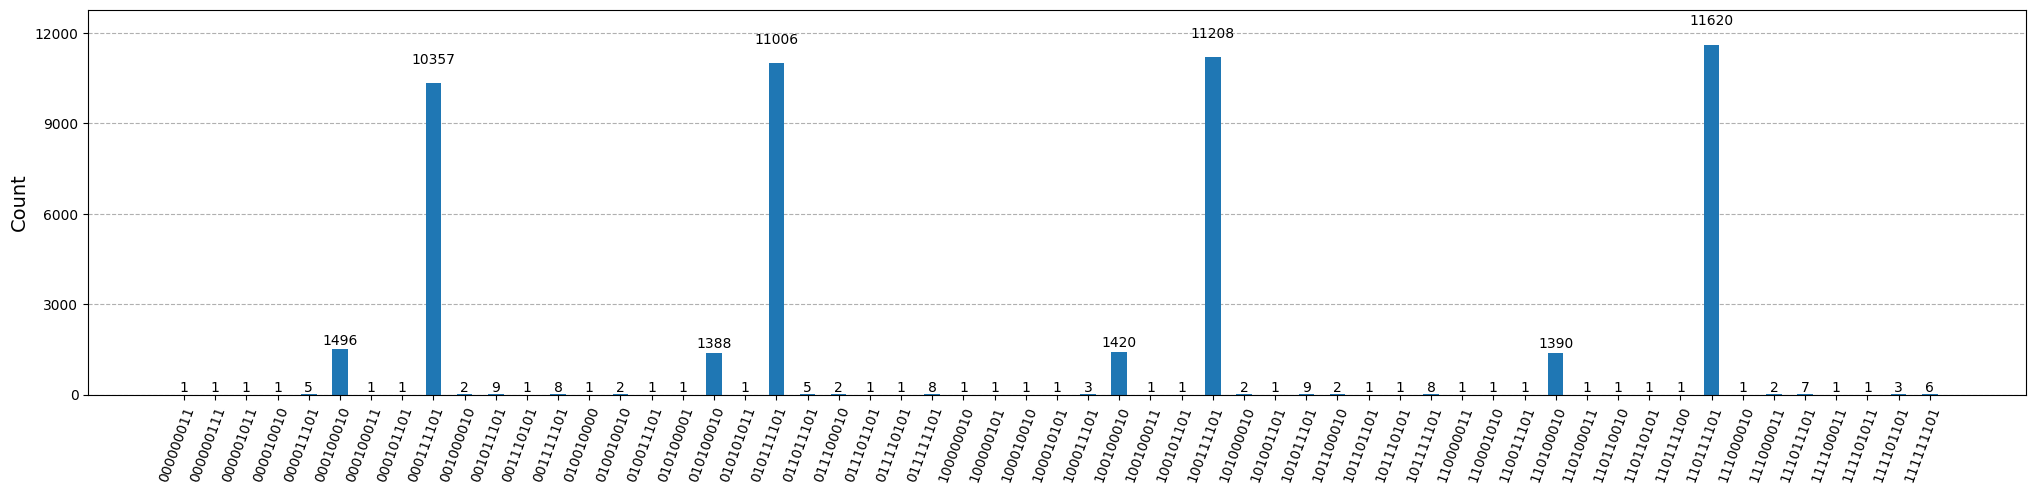


Probability estimation...

Sign estimation...
PE circuit data :
[PE Circuit before running?]: depth=1, num_qubits=9, size=1, gate count=OrderedDict([('PE', 1)])
[SE Circuit]: depth=8, num_qubits=10, size=17, gate count=OrderedDict([('measure', 10), ('h', 2), ('x', 2), ('c_Init', 1), ('ccircuit-399', 1), ('cstate_preparation', 1), ('barrier', 1)])

Eigenvalue and -vector construction...

Eigenvalue: 0.265625

Eigenvalue: 0.734375
Eigenvalue: 0.266, eigenvector: [ 0.716 -0.69 ]
Eigenvalue: 0.734, eigenvector: [0.703 0.716]
Done!


In [4]:
matr, eigvals_cl, eigvecs_cl = Generate_matrix(2,verbose=True)
print(f'eigval cl {eigvals_cl}, eigvecs cl {eigvecs_cl}')
vals, vecs = run_qPCA(matr, resolution=7, simulator=AerSimulator(), n_shots=50000, verbose=True)

## plots


🔍 Running resolution r=2
20 attempted runs, of which empty qpca runs: 0, resolution 2

🔍 Running resolution r=3
20 attempted runs, of which empty qpca runs: 0, resolution 3

🔍 Running resolution r=4
20 attempted runs, of which empty qpca runs: 0, resolution 4

🔍 Running resolution r=5
20 attempted runs, of which empty qpca runs: 0, resolution 5

🔍 Running resolution r=6
20 attempted runs, of which empty qpca runs: 0, resolution 6

🔍 Running resolution r=7
20 attempted runs, of which empty qpca runs: 0, resolution 7

🔍 Running resolution r=8
20 attempted runs, of which empty qpca runs: 0, resolution 8

🔍 Running resolution r=9
20 attempted runs, of which empty qpca runs: 0, resolution 9

🔍 Running resolution r=10
20 attempted runs, of which empty qpca runs: 0, resolution 10

🔍 Running resolution r=11
20 attempted runs, of which empty qpca runs: 0, resolution 11

🔍 Running resolution r=12
20 attempted runs, of which empty qpca runs: 0, resolution 12


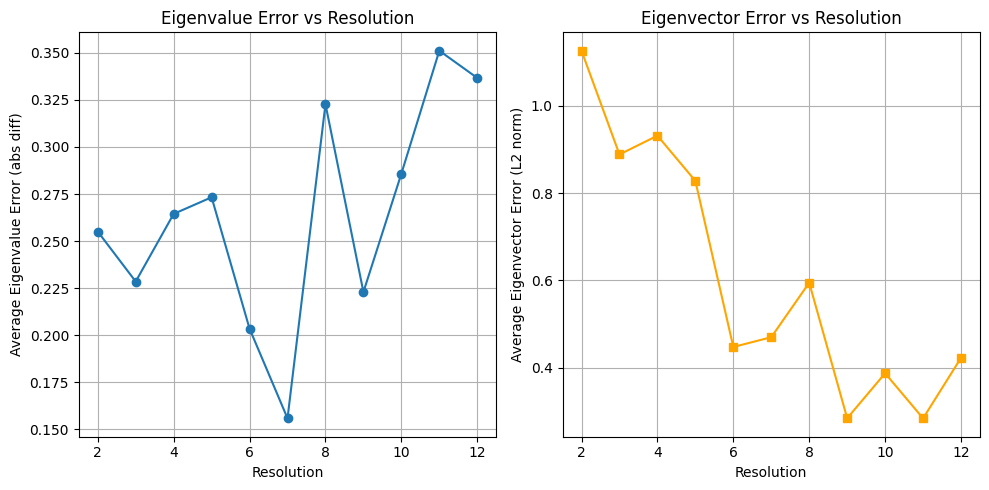

In [5]:
def err_per_res_qpca(n_repeats=20, matrix_size=2, resolutions=[2,3,4,5,6,7,8,9,10,11,12], shots=50000):
    eigval_errors_by_res = []
    eigvec_errors_by_res = []

    for r in resolutions:
        print(f"\n🔍 Running resolution r={r}")
        val_diffs = []
        vec_diffs = []
        ii = 0

        for _ in range(n_repeats):
            # Generate random Hermitian matrix + eigendecomp
            matr, eigvals_cl, eigvecs_cl = Generate_matrix(matrix_size,verbose=False)

            try:
                vals, vecs = run_qPCA(matr, resolution=r, simulator=AerSimulator(), n_shots=shots, verbose=False)
            except Exception as e:
                print(f"❌ qPCA failed: {e}")
                continue

            # Skip if no output
            if len(vals) == 0:
                #print("⚠️  Empty qPCA result, skipping.")
                ii = ii+1
                continue
            
            # After the inner loop ends
            if ii == n_repeats:
                print(f"⚠️  All {n_repeats} qPCA runs failed at resolution {r}. Skipping averaging.")
                eigval_errors_by_res.append(np.nan)
                eigvec_errors_by_res.append(np.nan)
                continue  # Skip this resolution

            for val, vec in zip(vals, vecs):
                # Find best classical match (by eigenvalue distance)
                idx = np.argmin(np.abs(np.array(eigvals_cl) - val))
                val_cl = eigvals_cl[idx]
                vec_cl = eigvecs_cl[:, idx]

                # Eigenvalue diff
                val_diffs.append(abs(val_cl - val))

                # Normalize vectors, ignore global phase
                norm_vec = vec / np.linalg.norm(vec)
                norm_cl = vec_cl / np.linalg.norm(vec_cl)
                phase_fix = np.vdot(norm_cl, norm_vec)
                aligned_vec = norm_vec * np.sign(phase_fix)

                # Eigenvector diff (L2 norm)
                vec_diffs.append(np.linalg.norm(norm_cl - aligned_vec))

        # Record average errors per resolution
        eigval_errors_by_res.append(np.mean(val_diffs))
        eigvec_errors_by_res.append(np.mean(vec_diffs))

        print(f'{n_repeats} attempted runs, of which empty qpca runs: {ii}, resolution {r}')

    return resolutions, eigval_errors_by_res, eigvec_errors_by_res


# Run and plot
resolutions, val_errors, vec_errors = err_per_res_qpca()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(resolutions, val_errors, marker='o')
plt.title("Eigenvalue Error vs Resolution")
plt.xlabel("Resolution")
plt.ylabel("Average Eigenvalue Error (abs diff)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(resolutions, vec_errors, marker='s', color='orange')
plt.title("Eigenvector Error vs Resolution")
plt.xlabel("Resolution")
plt.ylabel("Average Eigenvector Error (L2 norm)")
plt.grid(True)

plt.tight_layout()

plt.savefig("qPCA_resolution_error_plot.pdf")

plt.show()
    


🔍 Running resolution r=2
20 attempted runs, of which empty qpca runs: 0, resolution 2

🔍 Running resolution r=3
20 attempted runs, of which empty qpca runs: 0, resolution 3

🔍 Running resolution r=4
20 attempted runs, of which empty qpca runs: 0, resolution 4

🔍 Running resolution r=5
20 attempted runs, of which empty qpca runs: 0, resolution 5

🔍 Running resolution r=6
20 attempted runs, of which empty qpca runs: 0, resolution 6

🔍 Running resolution r=7
20 attempted runs, of which empty qpca runs: 0, resolution 7

🔍 Running resolution r=8
20 attempted runs, of which empty qpca runs: 0, resolution 8


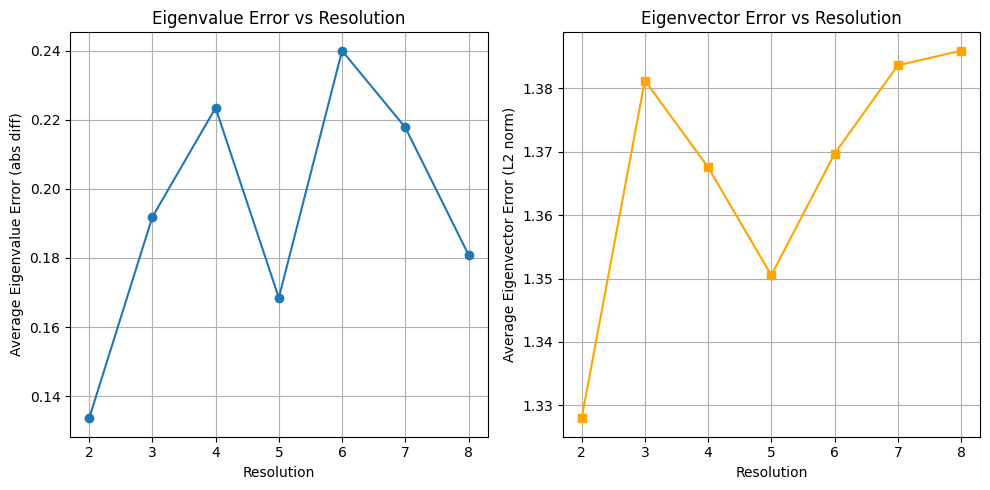

In [ ]:
resolutions, val_errors, vec_errors = err_per_res_qpca(n_repeats=20, matrix_size=4, resolutions=[2,3,4,5,6,7,8], shots=50000)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(resolutions, val_errors, marker='o')
plt.title("Eigenvalue Error vs Resolution")
plt.xlabel("Resolution")
plt.ylabel("Average Eigenvalue Error (abs diff)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(resolutions, vec_errors, marker='s', color='orange')
plt.title("Eigenvector Error vs Resolution")
plt.xlabel("Resolution")
plt.ylabel("Average Eigenvector Error (L2 norm)")
plt.grid(True)

plt.tight_layout()

plt.savefig("qPCA_resolution_error_plot_4x4.pdf")

plt.show()


🔍 Running resolution r=2
✅ Completed 20 runs (fails: 0) for resolution 2

🔍 Running resolution r=3
✅ Completed 20 runs (fails: 0) for resolution 3

🔍 Running resolution r=4
✅ Completed 20 runs (fails: 0) for resolution 4

🔍 Running resolution r=5
✅ Completed 20 runs (fails: 0) for resolution 5

🔍 Running resolution r=6
✅ Completed 20 runs (fails: 0) for resolution 6


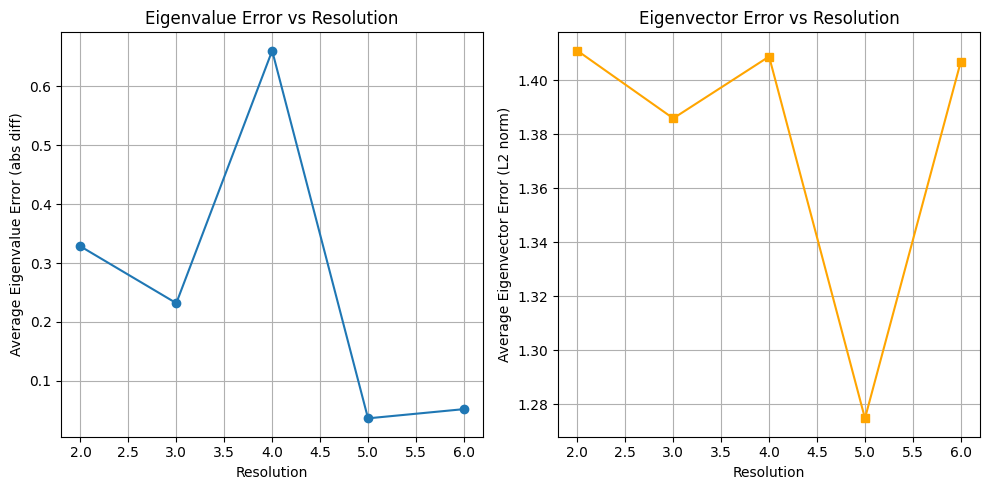

In [ ]:
#repeats for the same matrix
def err_per_res_qpca_single(n_repeats=20, matrix_size=4, resolutions=[2, 3, 4, 5, 6], shots=50000):
    eigval_errors_by_res = []
    eigvec_errors_by_res = []

    for r in resolutions:
        print(f"\n🔍 Running resolution r={r}")

        val_diffs = []
        vec_diffs = []
        fail_count = 0

        # Generate one fixed matrix and its classical eigendecomposition
        matr, eigvals_cl, eigvecs_cl = Generate_matrix(matrix_size, verbose=False)

        repeat_count = 0
        while repeat_count < n_repeats:
            try:
                vals, vecs = run_qPCA(matr, resolution=r, simulator=AerSimulator(), n_shots=shots, verbose=False)
            except Exception as e:
                print(f"❌ qPCA failed: {e}")
                fail_count += 1
                continue

            # Skip if no output
            if len(vals) == 0:
                fail_count += 1
                continue

            for val, vec in zip(vals, vecs):
                # Match to best classical eigenvalue
                idx = np.argmin(np.abs(np.array(eigvals_cl) - val))
                val_cl = eigvals_cl[idx]
                vec_cl = eigvecs_cl[:, idx]

                # Eigenvalue error
                val_diffs.append(abs(val_cl - val))

                # Align eigenvectors (up to global phase)
                norm_vec = vec / np.linalg.norm(vec)
                norm_cl = vec_cl / np.linalg.norm(vec_cl)
                phase_fix = np.vdot(norm_cl, norm_vec)
                aligned_vec = norm_vec * np.sign(phase_fix)

                # Eigenvector error
                vec_diffs.append(np.linalg.norm(norm_cl - aligned_vec))

            repeat_count += 1

        # Aggregate average errors for this resolution
        eigval_errors_by_res.append(np.mean(val_diffs))
        eigvec_errors_by_res.append(np.mean(vec_diffs))

        print(f"✅ Completed {repeat_count} runs (fails: {fail_count}) for resolution {r}")

    return resolutions, eigval_errors_by_res, eigvec_errors_by_res

# Run and plot
resolutions, val_errors, vec_errors = err_per_res_qpca_single()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(resolutions, val_errors, marker='o')
plt.title("Eigenvalue Error vs Resolution")
plt.xlabel("Resolution")
plt.ylabel("Average Eigenvalue Error (abs diff)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(resolutions, vec_errors, marker='s', color='orange')
plt.title("Eigenvector Error vs Resolution")
plt.xlabel("Resolution")
plt.ylabel("Average Eigenvector Error (L2 norm)")
plt.grid(True)

plt.tight_layout()

plt.savefig("qPCA_resolution_error_plot_4x4_single.pdf")

plt.show()
